## [CG&T] Project: Visualizing Alpha Complexes
### Amélie Royer

In [1]:
%matplotlib inline

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
import numpy as np
from operator import mul
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from scipy.misc import imread
from collections import defaultdict
from matplotlib import collections  as mc
from matplotlib import patches as mp
colors = ["#727272", "#f1595f", "#79c36a", "#599ad3", "#f9a65a", "#9e66ab", "#cd7058", "#d77fb3"]

In [4]:
### Sample data points
def generate_cloud_from_image(N, image, n_bounds=2, d_bounds=100, ax=None):
    """
    Sample N points uniformly from R², constrained on the shape given by the image (white <-> foreground)
    
    Args:
     * ``N`` (*int*): number of samples to draw.
     * ``image_path`` (*numpy array*): shape to draw samples from.
     * ``n_bounds`` (*int*): number of artifical samples to add on each boundary segment.
     * ``d_bounds`` (*float*): distance from the artificial boundary samples to the original sampling space.
     * ``ax`` (*matplotlib axis*): If None, nothing is plotted.
     
    Returns:
     * ``bounding_box`` (*[x_min, x_max, y_min, y_max]*): Bounding box of the sampling distribution.
     * ``samples`` (*matrix of size (n_samples + n_bounds x 4) x 2*): 2D coordinates of the samples.
    """
    # Threshold
    image[image > 125] = 255
    image[image < 125] = 0
    # Sample from the white pixels
    indices = np.random.choice(np.where(image.flatten() != 0)[0], size=N)
    samples = np.zeros((N, 2))
    samples[:, 0] = indices % image.shape[1]
    samples[:, 1] = indices / image.shape[1]
    # Boundary trick
    boundary_x = np.linspace(-d_bounds, image.shape[1] + d_bounds, n_bounds)
    boundary_y = np.linspace(-d_bounds, image.shape[0] + d_bounds, n_bounds)
    samples = np.concatenate((samples, 
                             np.dstack((-np.ones(n_bounds) * d_bounds, boundary_y))[0],
                             np.dstack((np.ones(n_bounds) * (image.shape[1] + d_bounds), boundary_y))[0],
                             np.dstack((boundary_x, - np.ones(n_bounds) * d_bounds))[0],
                             np.dstack((boundary_x, np.ones(n_bounds) * (image.shape[0] + d_bounds)))[0]
                             ), axis=0)    
    # Plot
    if ax is not None:
        plt.axis('off')
        ax.imshow(image, cmap='Greys_r', interpolation="nearest")
        ax.scatter(samples[:, 0], samples[:, 1], marker='+', color=colors[1], s=50)
        ax.set_xlim([- 5, image.shape[1] + 5])
        ax.set_ylim([- 5, image.shape[0] + 5])
        ax.set_axis_off()
    return [0, image.shape[1], 0, image.shape[0]], samples


def generate_cloud_from_text(N, txt, font_path=None, font_size=50, n_bounds=5, d_bounds=100, ax=None):
    """
    Given a font file and text string, uniformly samples ``N`` points from the corresponding shape.
    
    Args:
     * ``N`` (*int*): number of samples to draw.
     * ``txt`` (*str*): text to draw.
     * ``font_path`` (*str*): path to the font file to use.
     * ``n_bounds`` (*int*): number of artifical samples to add on each boundary segment.
     * ``d_bounds`` (*float*): distance from the artificial boundary samples to the original sampling space.
     * ``ax`` (*matplotlib axis*): If None, nothing is plotted.
     
    Returns:
     * ``bounding_box`` (*[x_min, x_max, y_min, y_max]*): Bounding box of the sampling distribution.
     * ``samples`` (*matrix of size (n_samples + n_bounds x 4) x 2*): 2D coordinates of the samples.
    """
    # Draw text
    from PIL import Image, ImageFont, ImageDraw
    image = Image.new("RGBA", (300, 100), (0, 0, 0))
    drawer = ImageDraw.Draw(image)
    drawer.fontmode = "1"
    if font_path is None:
        drawer.text((0, 0), txt, (255, 255, 255))
    else:
        drawer.text((0, 0), txt, (255, 255, 255), font=ImageFont.truetype(font_path, font_size))
    image = np.array(image)[:, :, 0]
    # Crop the image
    aux = np.where(np.sum(image, axis=0) != 0)[0]; image = image[:, aux[0]:aux[-1]]
    aux = np.where(np.sum(image, axis=1) != 0)[0]; image = image[aux[0]:aux[-1], :]
    image = np.flipud(image)
    return generate_cloud_from_image(N, image, n_bounds, d_bounds, ax)

In [5]:
### Auxillary functions
def orientation(pts):
    """
    Given an ordered list of points, return  True iff they are given in clockwise order.
    """
    orient = sum(pts[(i + 1) % len(pts)][0] * p[1] - pts[(i + 1) % len(pts)][1] * p[0] for i, p in enumerate(pts))
    return (orient > 0)

def is_in(p, bounding_box):
    """
    Return True iff the 2D point p lies in (or on) the given bounding box.
    """
    return ((p[0] >= bounding_box[0]) and (p[0] <= bounding_box[1]) 
                and (p[1] >= bounding_box[2]) and (p[1] <= bounding_box[3]))

def is_region_in(region, bounding_box):
    """
    Return True iff the collection of line segments ``region`` entirely lies in (or on) the given bounding box.
    """
    return reduce(mul, (is_in(p, bounding_box) for p in region), 1)

def is_id(p, q):
    """
    Return True iff the 2D points p and q are equal.
    """
    return (p[0] == q[0]) and (p[1] == q[1])

def distance(p, q):
    """
    Return the Euclidean distance between the 2D points p and q.
    """
    return np.sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2)

def is_in_circle(p, c, r):
    """
    Returns True iff p lies in (or on) the circle of center ``c`` and radius ``r``.
    """
    return distance(c, p) <= r

def angle(c, p):
    """ 
        Compute the angle of point ``p`` (in [0; 2pi]) in a circle of center ``c``.
    """
    v1 = np.array([1, 0])
    v2 = (p - c) / np.linalg.norm(p - c)
    aux = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))
    return aux if p[1] > c[1] else 2 * np.pi - aux

def arc(center, r, p, q, precision=100, color='r'):
    """
    Return the (clockwise) circle arc between points ``p`` and ``q``, both lying on the circle of
    center ``c`` and radius ``r``.
    The parameter ``precision`` determines the number of points on the plot.     
    """
    # Generate the full circle
    t = np.linspace(0, 2*np.pi, precision)
    ap, aq = angle(center, p), angle(center, q)
    # Remove angles not in the arc
    if ap < aq:
        t = t[(t < ap) | (t > aq)]
    else:
        t = t[(t < ap) & (t > aq)]
    # Add circle arc boundaries
    t = np.insert(t, np.searchsorted(t, ap), ap)
    t = np.insert(t, np.searchsorted(t, aq), aq)
    # Plot
    if ap < aq:
        t1 = t[t <= ap]
        t2 = t[t > ap]
        return [zip(center[0] + r * np.cos(t1), center[1] + r * np.sin(t1)), 
                zip(center[0] + r * np.cos(t2), center[1] + r * np.sin(t2))]
    else:
        return [zip(center[0] + r * np.cos(t), center[1] + r * np.sin(t))]

In [6]:
#### Voronoi Diagram
def voronoi_diagram(samples, ax=None):
    """
    Compute the Voronoi diagram of the given samples and return the regions inside the convex hull with their centers.
    
    Args:
     * ``samples`` (*matrix of size n_samples x 2*): 2D coordinates of the samples.
     * ``ax`` (*matplotlib axis*): If None, nothing is plotted.
     
    Returns:
     * ``vor_cells`` (*list of (center, region edges)*): Pre-parsed valid and clockwise oriented Voronoi regions.
     * ``vor_ridges`` (*list of (center, region edges)*): Pre-parsed list of edges and associated Voronoi centers.
    """
    # Extract Voronoi regions
    vor = Voronoi(samples, qhull_options="Q0")
    # Voronoi Edge index -> Center of Voronoi cells incident to the edge 
    n = len(vor.vertices)
    vor_ridges = {min(vertices) * n + max(vertices): 
                  ((centers[0], vor.points[centers[0]]), (centers[1], vor.points[centers[1]]))
                  for vertices, centers in zip(vor.ridge_vertices, vor.ridge_points) if not -1 in vertices} 
    # Remove "infinite" regions
    vor_cells = [(center, # center
                 vor.vertices[vor.regions[vor.point_region[i]], :], # vertices coordinates
                 vor.regions[vor.point_region[i]],                  # vertices index
                 [min(p, q) * n + max(p, q)                         # edges index
                  for (p, q) in zip(vor.regions[vor.point_region[i]], 
                                    (vor.regions[vor.point_region[i]][1:] + [vor.regions[vor.point_region[i]][0]]))]) 
                for i, center in enumerate(vor.points) 
            if (vor.point_region[i] != -1) and (not -1 in vor.regions[vor.point_region[i]])]
    # Orient each region's edges in clockwise order
    vor_cells = [(center, np.array(region), np.array(region_indices), edges) if orientation(region) else 
                 (center, np.array(region[::-1]), np.array(region_indices[::-1]), edges[:-1][::-1] + [edges[-1]])
                   for center, region, region_indices, edges in vor_cells]
    return vor_cells, vor_ridges

In [7]:
def plot_voronoi_regions(ax, vor_cells, bounding_box):
    """
    Plot the given Voronoi regions.
    
    Args:
     * ``ax`` (*matplotlib axis*): Plotting axis.   
     * ``vor_regions`` (*list of (center, region edges)*): Pre-parsed valid and clockwise oriented Voronoi regions.
     * ``bounding_box`` (*[x_min, x_max, y_min, y_max]*): Bounding box of the sampling distribution.    
    """
    # Build vertices and edges list
    edges_collection = []
    dashed_edges_collection = []
    vertices = [0] * len(vor_cells)   
    i = 0
    for (center, region, _, _) in vor_cells:
        if is_in(center, bounding_box):
            vertices[i] = center
            if is_region_in(region, bounding_box):
                edges_collection.extend(zip(region, list(region[1:]) + [region[0]]))
            else:
                dashed_edges_collection.extend(zip(region, list(region[1:]) + [region[0]]))
            i += 1
    vertices = np.array(vertices[:i])
    ax.add_collection(mc.LineCollection(edges_collection, color=colors[3], linewidths=1))
    ax.add_collection(mc.LineCollection(dashed_edges_collection, color=colors[3], linewidths=1, linestyle='--'))
    ax.scatter(vertices[:, 0], vertices[:, 1], color=colors[1], zorder=2, s=3)
    ax.set_xlim([bounding_box[0] - 5, bounding_box[1] + 5])
    ax.set_ylim([bounding_box[2] - 5, bounding_box[3] + 5])
    ax.set_axis_off()   
    ax.set_title('Voronoi Diagram', fontsize=18)
    
def plot_delaunay(ax, vor_ridges, bounding_box):
    """
    Plot the Delaunay triangulation from the Voronoi cells' edges.
    
    Args:
     * ``ax`` (*matplotlib axis*): Plotting axis.   
     * ``vor_ridges`` (*list of (center, region edges)*): Pre-parsed list of edges and associated Voronoi centers.
     * ``bounding_box`` (*[x_min, x_max, y_min, y_max]*): Bounding box of the sampling distribution.    
    """
    # Build vertices and triangles list
    adjacency = defaultdict(lambda: [])
    vertices = {}
    for (ip, p), (iq, q) in vor_ridges.itervalues():
        if is_region_in([p, q], bounding_box):
            vertices[ip] = p
            vertices[iq] = q
            adjacency[min(ip, iq)].append(max(ip, iq))
    triangles = []
    for p, neighbours in adjacency.items():
        auxp = set(adjacency[p])
        for i, q in enumerate(neighbours):
            auxq = auxp.intersection(set(adjacency[q]))
            for r in neighbours[i+1:]:
                if max(q,r) in adjacency[min(q, r)] and len(list(auxq.intersection(adjacency[r]))) == 0:
                    triangles.append(mp.Polygon([vertices[p], vertices[q], vertices[r]], closed=True))
    # Plot            
    vertices = np.array(vertices.values())
    ax.scatter(vertices[:, 0], vertices[:, 1], color=colors[1], zorder=2, s=5)
    ax.add_collection(mc.PatchCollection(triangles, color=(0.97, 0.65, 0.35, 0.32), edgecolor=colors[4]))
    ax.set_axis_off()
    ax.set_xlim([bounding_box[0] - 5, bounding_box[1] + 5])
    ax.set_ylim([bounding_box[2] - 5, bounding_box[3] + 5])
    ax.set_title('Delaunay Triangulation', fontsize=18)
    
def plot_delaunay_shape(ax, vor_ridges, bounding_box):
    """
    Plot the Delaunay's hull. 
    """
    # Build vertices and triangles list
    adjacency = defaultdict(lambda: [])
    vertices = {}
    for (ip, p), (iq, q) in vor_ridges.itervalues():
        if is_region_in([p, q], bounding_box):
            vertices[ip] = p
            vertices[iq] = q
            adjacency[min(ip, iq)].append(max(ip, iq))
    triangles_edges = defaultdict(lambda: 0)
    triangles = []
    indexing = lambda x, y: (min(x, y), max(x, y))
    for p, neighbours in adjacency.items():
        auxp = set(adjacency[p])
        for i, q in enumerate(neighbours):
            auxq = auxp.intersection(set(adjacency[q]))
            for r in neighbours[i+1:]:
                if max(q,r) in adjacency[min(q, r)]:
                    # Add edges triangles
                    triangles_edges[indexing(p, q)] = triangles_edges[indexing(p, q)] + 1
                    triangles_edges[indexing(p, r)] = triangles_edges[indexing(p, r)] + 1
                    triangles_edges[indexing(r, q)] = triangles_edges[indexing(r, q)] + 1
                    if len(list(auxq.intersection(adjacency[r]))) == 0:
                        triangles.append(mp.Polygon([vertices[p], vertices[q], vertices[r]], closed=True))
    # Plot            
    vertices = np.array(vertices.values())
    ax.scatter(vertices[:, 0], vertices[:, 1], color=colors[1], zorder=2, s=5, alpha=0.5)
    ax.add_collection(mc.PatchCollection(triangles, color=(0.97, 0.65, 0.35, 0.12), edgecolor=None, linewidth=0))
    edges = [[vertices[x1], vertices[x2]] for (x1, x2), y in triangles_edges.iteritems() if y == 1]
    ax.add_collection(mc.LineCollection(edges, color=colors[3], linewidths=2))
    ax.set_axis_off()
    ax.set_xlim([bounding_box[0] - 5, bounding_box[1] + 5])
    ax.set_ylim([bounding_box[2] - 5, bounding_box[3] + 5])
    ax.set_title('Delaunay Triangulation Hull', fontsize=18)

In [8]:
### Alpha Complexes
def line_circle_intersection(p, q, center, r):    
    """
    Return [p2, q2] the segment intersection of [p, q] with the circle of center ``center`` and radius ``r``;
    or an empty list if the intersection does not exist.
    """
    cp = is_in_circle(p, center, r)
    cq = is_in_circle(q, center, r)
    # If p and q are both in the circle -> clip to [p, q]
    if cp and cq:
        return [(p, q)], True, True
    # Otherwise, compute the intersection
    # Finite slope
    if p[0] != q[0]:
        order = p[0] <= q[0]
        # Express the line equation as y = slope * x + intersect
        slope = (q[1] - p[1]) / (q[0] - p[0])
        intersect = q[1] - slope * q[0]
        # Express the intersection problem as a quadratic equation ax2 + bx + c
        a = slope**2 + 1
        b = 2 * (slope * (intersect - center[1]) - center[0])
        c = center[0]**2 + (intersect - center[1])**2 - r**2
        # No intersection -> clip to circle
        delta = b**2 - 4*a*c
        if delta <= 0:
            return [], False, False
        # Intersection -> clip to [p2, q2] n [p, q]
        else:
            pt1 = p; pt2 = q
            is_in_pq = lambda z: ((z >= int(order) * p[0] + (1 - int(order)) * q[0]) 
                        and (z <= int(order) * q[0] + (1 - int(order)) * p[0]))
            check = False # check will be True iff [p2, q2] n [p, q] is empty
            if not cp:
                x = (- b - np.sqrt(delta)) / (2 * a) if order else (- b + np.sqrt(delta)) / (2 * a)
                pt1 = np.array([x, slope*x + intersect])
                check = not is_in_pq(x)
            if not cq:
                x = (- b + np.sqrt(delta)) / (2 * a) if order else (- b - np.sqrt(delta)) / (2 * a)
                pt2 = np.array([x, slope*x + intersect])
                check = (check or cp) and (not is_in_pq(x))
            #print p, q, cp, cq, check, order
            return ([], False, False) if check else ([(pt1, pt2)], cp, cq)
    # Infinite slope (same process, for the case of a vertical line)
    else:
        # No intersection
        if p[0] >= center[0] + r or p[0] <= center[0] - r:
             return [], False, False
        else:
            order = p[1] <= q[1]
            pt1 = p; pt2 = q
            is_in_pq = lambda z: ((z >= int(order) * p[1] + (1 - int(order)) * q[1]) 
                        and (z <= int(order) * q[1] + (1 - int(order)) * p[1]))
            check = False
            if not cp:
                y = (-np.sqrt(r**2 - (p[0] - center[0])**2) if order 
                     else np.sqrt(r**2 - (p[0] - center[0])**2)) + center[1]
                pt1 = np.array([p[0], y])
                check = not is_in_pq(y)
            if not cq:
                y = (np.sqrt(r**2 - (p[0] - center[0])**2) if order 
                     else -np.sqrt(r**2 - (p[0] - center[0])**2)) + center[1]
                pt2 = np.array([p[0], y])
                check = check and (not is_in_pq(y))
            return ([], False, False) if check else ([(pt1, pt2)], cp, cq)
    

def alpha_complex(samples, vor_regions, vor_ridges, r):
    """
    Jointly compute the alpha complex and Voronoi diagram of the given samples cloud.
    
    Args:
     * ``samples`` (*matrix of size n_samples x 2*): 2D coordinates of the samples.
     * ``vor_regions`` (*list of (center, region edges, edge indices)*): Precomputed region in the Voronoi diagram.
     * ``vor_ridges`` (*dictionnary edge index -> (x, y) center of neighboring Voronoi cell*)
     * ``r`` (*float*): Radius of the balls.
     
    Returns:
     * ``restricted_voronoi_cells``: Restricted Voronoi diagram structure.
     * ``alpha_complex_edges``: List of edges in the Alpha complex.
    """
    # Build the restricted Voronoi diagram
    restricted_voronoi_cells = [] 
    alpha_complex_cells = [[], []]
    triangles = defaultdict(lambda: [])
    for center, region, region_indices, edge_indices in vor_regions:
        restr_region = [] 
        for i, p in enumerate(region):
            q = region[(i + 1) % len(region)]
            inter, clip_p, clip_q = line_circle_intersection(p, q, center, r)
            if len(inter):
                restr_region.extend(inter)
                #alpha_complex_edges.append(vor_ridges[edge_indices[i]])
            # If triangles
                if clip_p and not edge_indices[i] in triangles[region_indices[i]]:
                    triangles[region_indices[i]].append(edge_indices[i])
                if clip_q and not edge_indices[i] in triangles[region_indices[(i + 1) % len(region)]]:
                    triangles[region_indices[(i + 1) % len(region)]].append(edge_indices[i])
                else:
                    alpha_complex_cells[0].append(edge_indices[i])
        restricted_voronoi_cells.append((center, restr_region)) 
    # Build apla complex (distinguish edges from triangles)
    seen_edges = []
    # Define triangles
    for vertex, incident_edges in triangles.iteritems():
        if len(incident_edges) == 3:
            vertices = [(x, y) for e in incident_edges for (x, y) in vor_ridges[e]]
            _, aux = np.unique([x[0] for x in vertices], return_index=True)
            alpha_complex_cells[1].append([vertices[i][1] for i in aux])
            seen_edges.extend(incident_edges)
    # Remove duplicate edges
    alpha_complex_cells[0] = list(set(alpha_complex_cells[0]) - set(seen_edges))
    alpha_complex_cells[0] = map(lambda x: [y[1] for y in vor_ridges[x]], alpha_complex_cells[0])
    return restricted_voronoi_cells, alpha_complex_cells

In [9]:
def plot_restricted_voronoi_diagram(ax, restricted_voronoi_cells, r):
    """
    Plot the restricted voronoi diagram.
    
    Args:
     * ``ax``: Matplotlib axis object.
     * ``restricted_voronoi_cells``: Restricted Voronoi diagram structure.
     * ``r``: Ball radius
    """    
    # Build line collection and vertices
    edges_collection = []
    arcs_collection = []
    vertices = [0] * len(restricted_voronoi_cells)
    for i, (c, cell) in enumerate(restricted_voronoi_cells):
        vertices[i] = c
        if len(cell) == 0:            
            arcs_collection.extend(arc(c, r, [c[0] + r, c[1] - 1e-5], [c[0] + r, c[1] + 1e-5]))
        else:
            end_pt = cell[-1][1]
            for i, (p, q) in enumerate(cell):
                if not is_id(end_pt, p):
                    arcs_collection.extend(arc(c, r, end_pt, p))
                edges_collection.append([p, q])
                end_pt = q
    # Plot
    vertices = np.array(vertices)
    ax.scatter(vertices[:, 0], vertices[:, 1], color=colors[4], marker='o', s=5, alpha=0.4)
    ax.add_collection(mc.LineCollection(edges_collection, color=colors[2], linewidths=1))
    ax.add_collection(mc.LineCollection(arcs_collection, color=colors[1], linewidths=1))
    ax.set_title("Restricted Voronoi Diagram", fontsize=18)
    ax.set_axis_off()   

def plot_alpha_complex(ax, centers, alpha_complex_cells):
    """
    Plot the alpha complex.
    
    Args:    
     * ``ax``: Matplotlib axis object.
     * ``centers``: Numpy array containing the set of input poinrs, S
     * ``alpha_complex_edges``: List of edges in the Alpha complex.
    """    
    edges, triangles = alpha_complex_cells
    ax.add_collection(mc.PatchCollection([mp.Polygon(x, closed=True) for x in triangles], 
                                         color=(0.97, 0.65, 0.35, 0.32), edgecolor=colors[4]))
    ax.add_collection(mc.LineCollection(edges, color=colors[4], linewidths=1))
    ax.scatter(centers[:, 0], centers[:, 1], color=colors[1], zorder=2, s=3)
    ax.set_title("Alpha Complex", fontsize=18)
    ax.set_axis_off()
    
def plot_alpha_shape(ax, centers, alpha_complex_cells):
    contour = defaultdict(lambda: 0)
    edges, triangles = alpha_complex_cells
    indexing = lambda x, y: (x[0], x[1], y[0], y[1]) if x[0] < y[0] else (y[0], y[1], x[0], x[1]) if (x[0] > y[0] or y[1] < x[1]) else (x[0], x[1], y[0], y[1])
    for (p, q, r) in triangles:
        contour[indexing(p, q)] += 1
        contour[indexing(r, q)] += 1
        contour[indexing(p, r)] += 1
    edges.extend([([a,b], [c,d]) for (a,b,c,d), v in contour.iteritems() if v == 1])
    ax.add_collection(mc.PatchCollection([mp.Polygon(x, closed=True) for x in triangles], 
                                         color=(0.97, 0.65, 0.35, 0.12), edgecolor=colors[4], linewidth=0))
    ax.add_collection(mc.LineCollection(edges, color=colors[3], linewidths=2))
    ax.scatter(centers[:, 0], centers[:, 1], color=colors[1], zorder=2, s=3)
    ax.set_title("Alpha Complex shape", fontsize=18)
    ax.set_axis_off()

## Additional examples

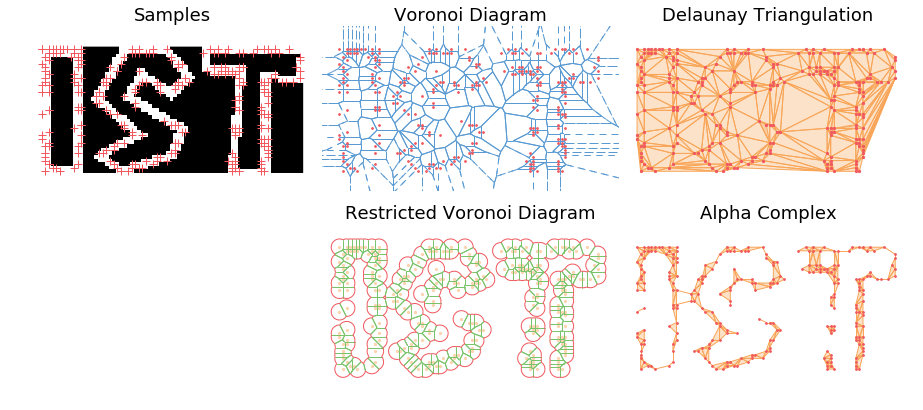

In [12]:
plt.rcParams['figure.figsize'] = 16, 6.5
fig, ((ax1, ax2, ax3), (ax0, ax4, ax5)) = plt.subplots(2, 3, sharex=True, sharey=True)
bounding_box, samples = generate_cloud_from_text(300, "ist", ax=ax1,
                                                 font_path="resources/Super Mario Bros.ttf", font_size=45)
ax1.set_title("Samples", fontsize=18)
# Voronoi
vor_regions, vor_ridges = voronoi_diagram(samples)
plot_voronoi_regions(ax2, vor_regions, bounding_box)
plot_delaunay(ax3, vor_ridges, bounding_box)
# Alpha Complex
r = 2.3
restricted_voronoi_cells, alpha_complex_edges = alpha_complex(samples, vor_regions, vor_ridges, r)
plot_restricted_voronoi_diagram(ax4, restricted_voronoi_cells, r)
plot_alpha_complex(ax5, np.array([x[0] for x in restricted_voronoi_cells]), alpha_complex_edges)
plt.subplots_adjust(wspace=0, hspace=0.2)
ax0.set_axis_off()
plt.show()

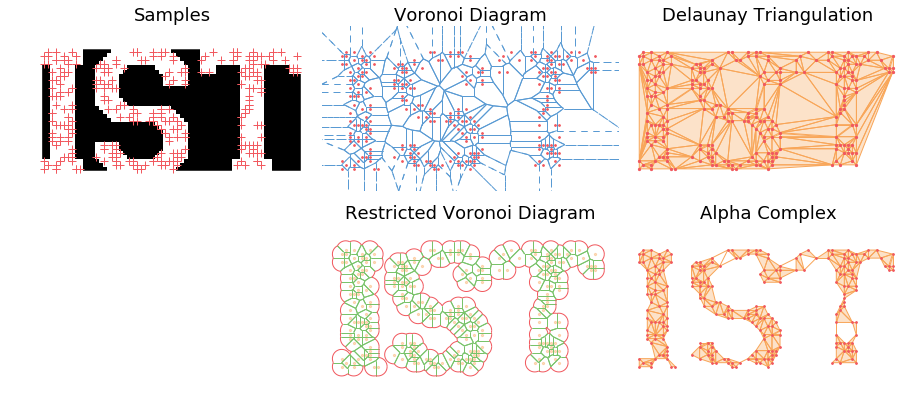

In [13]:
plt.rcParams['figure.figsize'] = 16, 6.5
fig, ((ax1, ax2, ax3), (ax0, ax4, ax5)) = plt.subplots(2, 3, sharex=True, sharey=True)
bounding_box, samples = generate_cloud_from_text(300, "ist", font_path="resources/varsity_regular.ttf", ax=ax1)
ax1.set_title("Samples", fontsize=18)
# Voronoi
vor_regions, vor_ridges = voronoi_diagram(samples)
plot_voronoi_regions(ax2, vor_regions, bounding_box)
plot_delaunay(ax3, vor_ridges, bounding_box)
# Alpha Complex
r = 2.3
restricted_voronoi_cells, alpha_complex_edges = alpha_complex(samples, vor_regions, vor_ridges, r)
plot_restricted_voronoi_diagram(ax4, restricted_voronoi_cells, r)
plot_alpha_complex(ax5, np.array([x[0] for x in restricted_voronoi_cells]), alpha_complex_edges)
plt.subplots_adjust(wspace=0, hspace=0.2)
ax0.set_axis_off()
plt.show()

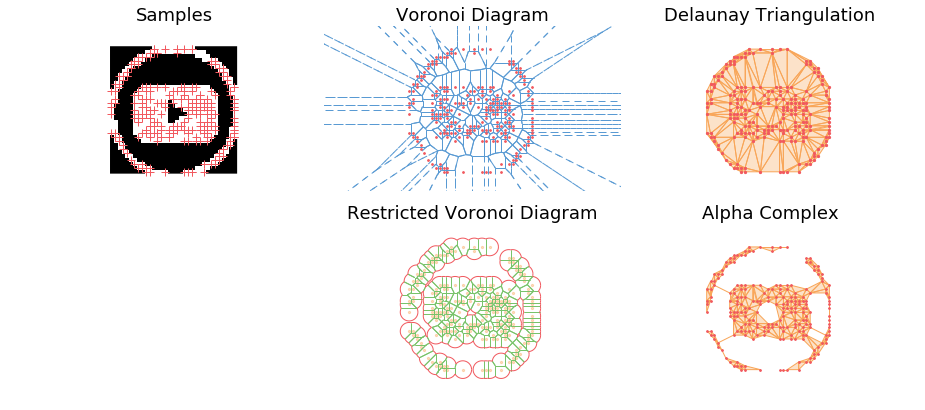

In [14]:
plt.rcParams['figure.figsize'] = 16, 6.5
fig, ((ax1, ax2, ax3), (ax0, ax4, ax5)) = plt.subplots(2, 3, sharex=True, sharey=True)
bounding_box, samples = generate_cloud_from_text(300, "l", font_path="resources/social_shapes.ttf", ax=ax1)
ax1.set_title("Samples", fontsize=18)
# Voronoi
vor_regions, vor_ridges = voronoi_diagram(samples)
plot_voronoi_regions(ax2, vor_regions, bounding_box)
plot_delaunay(ax3, vor_ridges, bounding_box)
# Alpha Complex
r = 2.3
restricted_voronoi_cells, alpha_complex_edges = alpha_complex(samples, vor_regions, vor_ridges, r)
plot_restricted_voronoi_diagram(ax4, restricted_voronoi_cells, r)
plot_alpha_complex(ax5, np.array([x[0] for x in restricted_voronoi_cells]), alpha_complex_edges)
plt.subplots_adjust(wspace=0, hspace=0.2)
ax0.set_axis_off()
plt.show()

## Animated example

In [40]:
import matplotlib.animation as animation
plt.rcParams['figure.figsize'] = 10, 10
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
# Sample
image = imread("resources/clipart2.jpg")[::-1, :, 0]
bounding_box, samples = generate_cloud_from_image(500, image)
vor_regions, vor_ridges = voronoi_diagram(samples)
r = 5.

def animate(i):
    global r
    ax1.clear()
    ax2.clear()
    restricted_voronoi_cells, alpha_complex_edges = alpha_complex(samples, vor_regions, vor_ridges, r)
    plot_restricted_voronoi_diagram(ax1, restricted_voronoi_cells, r)
    plot_alpha_complex(ax2, np.array([x[0] for x in restricted_voronoi_cells]), alpha_complex_edges)
    plt.subplots_adjust(wspace=0, hspace=0)
    r += 0.8
    ax1.set_xlim([bounding_box[0] - 5, bounding_box[1] + 5])
    ax1.set_ylim([bounding_box[2] - 5, bounding_box[3] + 5])
    ax2.set_xlim([bounding_box[0] - 5, bounding_box[1] + 5])
    ax2.set_ylim([bounding_box[2] - 5, bounding_box[3] + 5])
    return (ax1, ax2)

ani = animation.FuncAnimation(fig, animate, np.arange(1, 120), interval=25)
ani.save('animation2.gif', writer='imagemagick', fps=9)
plt.close()

# 15 minutes of Computational Geometry
## [Tea Talk] 05.07.2016

#### Level 0: The point cloud
 * $S$, Set of 2D coordinates
 * No shape information

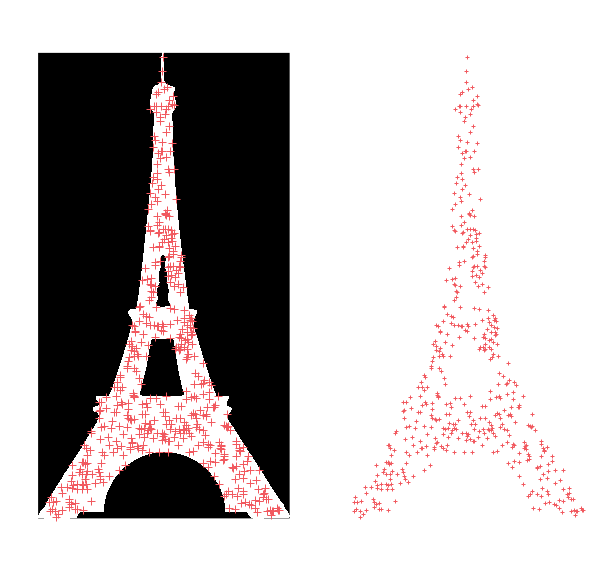

In [10]:
plt.rcParams['figure.figsize'] = 10, 10
N = 500
np.random.seed(41)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
image = imread("resources/clipart2.jpg")[::-1, :, 0]
bounding_box, samples = generate_cloud_from_image(N, image, ax=ax1)
ax2.scatter(samples[:, 0], samples[:, 1], marker='+', color=colors[1])
plt.show()

#### Convex hull

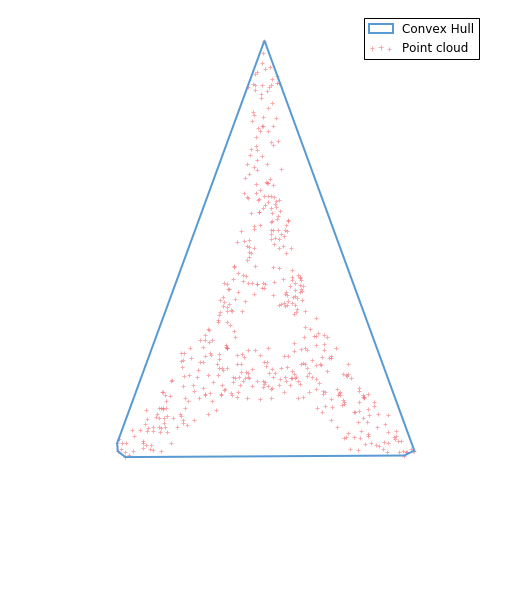

In [11]:
plt.rcParams['figure.figsize'] = 8, 10
N = 500
np.random.seed(41)
from scipy.spatial import ConvexHull
hull = ConvexHull(samples[:N])
plt.fill(samples[hull.vertices,0], samples[hull.vertices,1], color=colors[3], lw=2, fill=False, label="Convex Hull")
plt.scatter(samples[:N, 0], samples[:N, 1], marker='+', color=colors[1], alpha=0.5, label="Point cloud")
plt.axis('off')
plt.legend()
plt.show()

Basic notion of shape. However no concavities, no holes.

#### Delaunay Triangulation [Voronoi Diagram]
 * For each point $u$ in $S$, define its Voronoi cell:
     * $V_u = \{x \mbox{ s.t. } \forall v \in S\setminus\{u\}\ ||x - u || \leq ||x - v||\}$
     * The equality cases form the boundary of the Voronoi cell.
     
 * The Delaunay triangulation is the dual of the Voronoi diagram.
    * Edge $(u, v)$ in Delaunay iff $V_u \cap V_v \neq \varnothing$ 
    * Allow for concavity by adding artificial boundary samples and removing the corresponding triangles in the end.

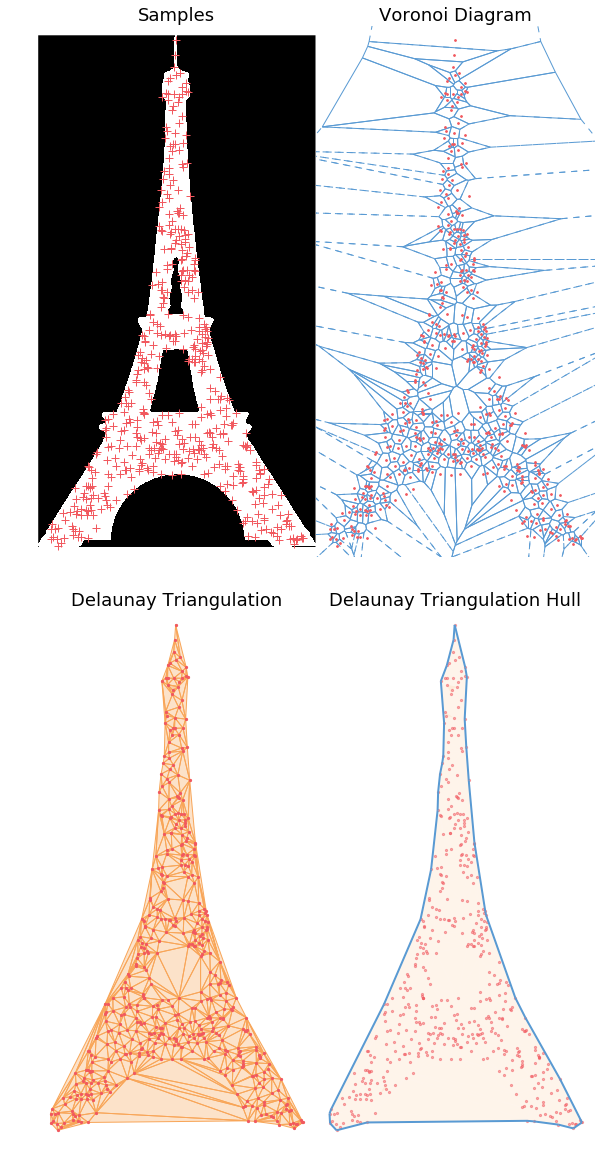

In [12]:
plt.rcParams['figure.figsize'] = 10, 20
np.random.seed(41)
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
image = imread("resources/clipart2.jpg")[::-1, :, 0]
bounding_box, samples = generate_cloud_from_image(N, image, ax=ax1)
ax1.set_title("Samples", fontsize=18)
vor_cells, vor_ridges = voronoi_diagram(samples)
plot_voronoi_regions(ax2, vor_cells, bounding_box)
plot_delaunay(ax3, vor_ridges, bounding_box)
plot_delaunay_shape(ax4, vor_ridges, bounding_box)
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

Still, holes are not captured with this construction...

From a higher perspective, we want to understand the homology group of the object (~holes).


#### Alpha Complexes [Restricted Delaunay Diagram]

 * For a radius $r$, For each point $u$ in $S$, define its **restricted** Voronoi cell:
     * $V_u(r) = V_u \cap B_r(u)$
     * When $r$ is big enough, $V_u(r) = V_u$.
     
 * The Alpha complex is the dual of the Voronoi diagram.
    * Edge $(u, v)$ in Alpha iff $V_u(r) \cap V_v(r) \neq \varnothing$ 
    * In particular, included in the Delaunay triangulation

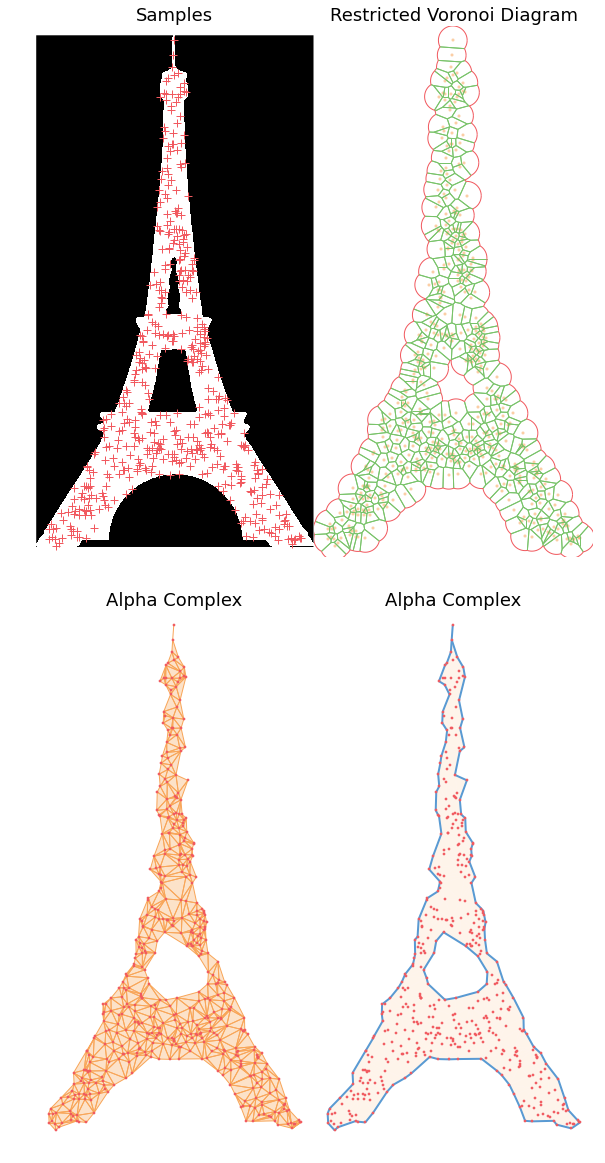

In [35]:
plt.rcParams['figure.figsize'] = 10, 20
np.random.seed(41)
N = 500
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
image = imread("resources/clipart2.jpg")[::-1, :, 0]
bounding_box, samples = generate_cloud_from_image(N, image, ax=ax1)
ax1.set_title("Samples", fontsize=18)
vor_regions, vor_ridges = voronoi_diagram(samples)
r = 53
restricted_voronoi_cells, alpha_complex_edges = alpha_complex(samples, vor_regions, vor_ridges, r)
plot_restricted_voronoi_diagram(ax2, restricted_voronoi_cells, r)
plot_alpha_complex(ax3, np.array([x[0] for x in restricted_voronoi_cells]), alpha_complex_edges)
plot_alpha_shape(ax4, np.array([x[0] for x in restricted_voronoi_cells]), alpha_complex_edges)
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

Now we capture the correct shape

However, how to find the correct radius $r$ of the $\alpha$ balls tha generalizes for the whole cloud?


#### Weighted Complexes

Add a weight $w_u$ to each point $u \in S$.

Define the so **power distance** between $u \in S$ and any $x \in \mathbb R ^2$
\begin{align*}
\pi(u, x) = ||u - x||^2 - w_u
\end{align*}

**Intuition**: See each point $u$ as a sphere of center $u$ and radius $\sqrt{w_u}$

For some applications, weights can be inferred from real data (e.g. molecul structure modeling or density in the point cloud)

<img src="./full.png">
https://www.jasondavies.com/power-diagram/

#### Filtration and Persistence

*Idea*: Keep track of the birth and death of cycles over time when increasing the radius.

**Example filtration:**
<img src="./animation2.gif">

Definition of death and birth

+ visual examples